# Introducción a las redes neuronales con ejemplos numéricos

------------------------------------

#### Diagrama general del aprendizajo supervisado en ML

![title](https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/aprendizajesupervizado.png)

#### ¿Qué es una red neuronal?

Según Wiki: es un modelo computacional vagamente inspirado en el comportamiento observado en su homólogo biológico.

 -Numeros inicialmente aleatorios $\in (0,1)$ asociados a cada conexión (llamados pesos) hacen alusión a la sinapsis.
 
 -Cada nodo de la RNA también es llamada neurona.
 
 -Hay una función de activación que determina si las señales activan o no cierta respuesta.
 
 -Las RNA procesan señales en paralelo.

#### Propagación hacia adelante:

- Genera pesos y bias aleatorios.
- Las entradas de la capa anterior se multiplican por los pesos por medio de una suma ponderada.
- Al resultado de la suma ponderada se le aplica una función de activación.
- La red neuronal arroja una predicción.

![title](https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/ANN_.png)

#### Tipos de funciones de activación:
Fuente: https://mlfromscratch.com/activation-functions-explained/#/
![title](https://mlfromscratch.com/content/images/2019/12/activation-functions.gif)

Tómese en cuenta lo siguiente.

- Los bias y pesos son inicialmente aleatorios, pero de alguna manera se deben ajustar mediante iteraciones.
- Cada conexión tiene un peso.
- Cada neurona tiene un bias. 

#### ¿Qué hace falta?
- Se requiere una métrica que mida qué tan cerca o lejos del valor esperado son las predicciones de la red (función de costo o de pérdida).
- Es necesario un algoritmo que minimize la función anterior.
- Si no se emplea una función de activación no lineal, la suma ponderada y toda la estructura de la red solamente proveerán transformaciones lineales.

### Para explicar cada parte, usaremos la implementación de Michael Nielsen en su libro Neural Networks and Deep Learning:

- Libro de acceso abierto: http://neuralnetworksanddeeplearning.com
- La presente versión ha sido modificada para fines didácticos:
    - Traducida al español.
    - Adaptada para regresión.
    - Adaptada a Python 3.

Consíderese lo siguiente:


- Función de costo: 
$C(w, b) ≡ \frac{1}{2} \Sigma_x || y(x) − a(x,w,b)||^2$, donde a es la predicción de la RNA.
- Métodos analíticos de minimización no son útiles para muchas variables.
- Se requiere un algoritmo para minimizar la función de costo: descenso del gradiente.
- El descenso del gradiente únicamente calcula gradientes, es el más simple de toda una familia de algoritmos de minimización.

#### Descenso del gradiente (intuición)

- La deducción no es propósito de esta notebook, pero cada nuevo paso en busca de la minimización de la función de costo, obedece la siguiente regla:

$ v -> v' = v - \eta \nabla C$, donde $v$ es $f(w, b)$

- Se da un paso en dirección opuesta al gradiente hasta minimizar la función de costo.

Fuente: https://kevinbinz.com/2019/05/26/intro-gradient-descent/

![title](https://kevinbinz.files.wordpress.com/2019/05/dualspace_explore.gif)

- Se quiere encontrar (x,y) tal que sea un mínimo en la superficie (función de costo).

Fuente: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

![title](https://miro.medium.com/max/819/1*hUd744hDEEGx0-ypWGhrkw.gif)

In [1]:
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [150]:
class neural_net:
    def __init__(self, X, Y, topology, epochs=50, lr=0.0001, bs=4, early_tol=100, scale=False):
        self.topology = topology
        self.epochs = epochs
        self.lr = lr
        self.bs = bs
        self.early_tol = early_tol
        self.scale = scale
    
        ntrain = int(0.8* len(X))
        indx = [ntrain]
        self.X_train, self.X_test = np.split(X, indx)
        self.Y_train, self.Y_test = np.split(Y, indx)
        
        if self.scale:
            self.scaler = StandardScaler()
            try:
                self.scaler.fit(X)
                self.X_train = self.scaler.transform(self.X_train)
                self.X_test = self.scaler.transform(self.X_test)
            except:
                self.scaler.fit(X.reshape(-1,1))
                self.X_train = self.scaler.transform(self.X_train.reshape(-1,1))
                self.X_test = self.scaler.transform(self.X_test.reshape(-1,1))

            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
        
        self.model = self.model()
        self.model.summary()
        
    def model(self):
        # Red neuronal
        model = K.models.Sequential()
        # Hidden layers

        for i, nodes in enumerate(self.topology):
            if i == 0:
                model.add(K.layers.Dense(self.topology[1], input_dim=self.topology[0], activation='relu'))
            elif i+1 < len(self.topology):
                model.add(K.layers.Dense(self.topology[i+1], activation='relu'))
        optimizer = K.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model                    
    
    def train(self):
        callbacks = [K.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                               min_delta=0.0,
                                               patience=self.early_tol,
                                               restore_best_weights=True)]
        print("Entrenando, por favor, espera...")
        self.history = self.model.fit(self.X_train,
                                      self.Y_train,
                                      validation_data=(self.X_test,
                                                       self.Y_test),
                                      epochs=self.epochs, batch_size=self.bs,
                                      callbacks=callbacks, verbose=0)
        print("¡Entrenamiento terminado!")
        return self.history
    
    def get_w_and_b(self, nlayer):
        weights, biases = self.model.layers[nlayer].get_weights()
        return weights, biases
    
    def predict(self, x):
        if type(x) == type([1]):
            x = np.array(x)
        if type(x) == type(1):
            x = np.array([x])
        if self.scale:
            try:
                x = self.scaler.transform(x)
            except:
                x = self.scaler.transform(x.reshape(-1,1))
        return self.model.predict(x)
        
    def plot(self):
        plt.plot(self.history.history['loss'], label='training set')
        plt.plot(self.history.history['val_loss'], label='validation set')
        plt.ylabel('loss function')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

In [151]:
def line(x):
    return 2*x + 3 + 0.5 * np.random.rand()

def quadratic(x):
    return x**2 + 0.5 * np.random.rand()

def quadtres(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = x[i, 0]**2 + x[i, 1] + x[i, 2]
    return y

In [152]:
npoints = 100
X = np.random.rand(npoints, 3)*10
# Y = line(X)
# Y = quadratic(X)
Y = quadtres(X)
# data =pd.DataFrame(zip(X,Y), columns=['x', 'y'])
data =pd.DataFrame(zip(X[:,0], X[:,1], X[:,2], Y), columns=['$x_1$', '$x_2$', '$x_3$', 'y'])
data.head(10)

,$x_1$,$x_2$,$x_3$,y
0,3.455872,3.016538,9.026047,23.985637
1,6.749939,6.336090,1.324419,53.222190
2,5.614330,0.076957,8.338254,39.935914
3,1.977897,5.956791,7.295881,17.164748
4,3.376275,0.970593,4.424084,16.793907
5,9.008616,9.421506,5.330414,95.907085
6,0.482818,8.846481,1.084822,10.164416
7,1.759803,1.843770,0.271427,5.212102
8,7.910754,4.501620,1.957418,69.039073
9,0.300022,6.421729,8.659776,15.171518


In [175]:
network = neural_net(X, Y, [3,100,1], epochs=50, bs=16, lr=0.1, scale=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [176]:
network.train()

Entrenando, por favor, espera...
¡Entrenamiento terminado!


In [177]:
w, b = network.get_w_and_b(nlayer=0)
print(b)

[ 1.0388068  -0.04237624  0.          0.          0.          1.0512313
 -0.03722895  0.         -0.00597239 -0.6690106   1.041963    1.0046318
 -0.6746116  -0.01890675  1.0176988   1.0794958   1.0310327  -0.65968364
  0.          0.         -0.10775152 -0.00771089 -0.01844343  0.
 -0.026328   -0.04383484  0.         -0.7234392   1.0490129   1.0373944
  0.          1.0663245   0.          0.         -0.683557    0.9916952
  1.0188001   1.01598    -0.72303957  0.          1.0848103  -0.00447179
 -0.01773631  0.          1.038454    0.          1.0754261   0.
  0.          1.0258771  -0.07098174 -0.667704   -0.65535164  1.0752702
  0.         -0.7645087   1.026847    1.0008413   1.0389104   0.
  1.0406672  -0.03839055  0.          0.          0.          0.
  0.          0.99529934  1.0765005   0.         -0.6952184   1.0613692
  1.0109853   1.0390471  -0.69963425  0.          1.0359831   1.0897307
 -0.6760683  -0.06937102  0.          0.          0.          0.
  0.         -0.68485445 

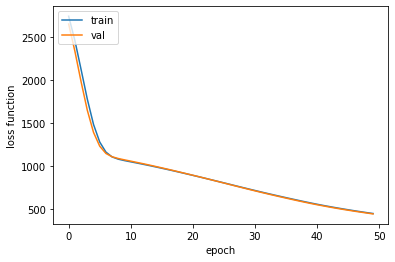

In [178]:
network.plot()

In [179]:
new_vector = np.array([5., 5, 6]).reshape(1,3)
prediction = network.predict(new_vector)
print(quadtres(new_vector))
print(prediction)

[36.]
[[22.31005]]


/home/isidro/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
